# Imports and Data

In [1]:
import numpy as np 
import networkx as nx 
import scipy as sc 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import defenses.rw
import defenses.spectral_add
import attack.sample as prop 
import defenses.addDel
import attack.distance_vec as dis1 

## Helper functions 

1. shfit is a small function to adjust mainly between graphs that are 0 indexed and 1 indexed 
2. scorer takes a mapping in the form of a dictionary that should be regard as the result of an attack and matches how many nodes map to themselve. If node ids are shuffled you will have to adjust the code to get if a mapping of a node is correct. 
3. copyToGraph -> This adds the edges of one graph ontop of another graph 
4. to_map converts a list of tuples [(a,b), (c,d), ...] to a hashmap with key-value pairs beings each pair. 

In [3]:
def shift(G, shift=1):
    mapping = {}
    for i in G.nodes:
        mapping[i] = i-shift
    return nx.relabel_nodes(G, mapping)

def scorer(n, answers):
    score = 0 
    for i in answers:
        if(answers[i] == i):
            score += 1
    return score / n

def copyToGraph(G, H):
    for (u,v) in H.edges():
        G.add_edge(u,v)
    return G

def to_map(lst):
    mp = {}
    for (a,b) in lst:
        mp[a] = b 
    return mp 

# Defenses 

here we perform all the defenses at once. 

In [4]:
G_original = nx.read_edgelist("data/email-Eu-core.txt", nodetype=int)

In [5]:
re_idx = [i for i in range(len(G_original))]
np.random.shuffle(re_idx)
labels = {i : re_idx[i] for i in range(len(G_original))}
G_shuffle = nx.relabel_nodes(G_original, labels)

In [6]:
G_rw = defenses.rw.Anon(G_original, [5,40])
Gs_proposed = []
for i in range(5):
    name = "proposedmethod/result_" + str(i+1) + ".txt"
    G = nx.empty_graph(1005)
    G = copyToGraph(G,shift(nx.read_edgelist(name, nodetype=int)) )
    nx.write_edgelist(G, "result_"+str(i)+".txt", data=False)
    Gs_proposed.append( G)

FileNotFoundError: [Errno 2] No such file or directory: 'proposedmethod/result_1.txt'

In [7]:
G_rw = defenses.rw.Anon(G_original, [2,100]) #2 hops 100 tried per hop

In [8]:
G_adddel = defenses.addDel.addDel(G_original)

In [9]:
G_spec = defenses.spectral_add.Anon(G_original, [1000])

1005
1005


# Utilities 

Measures of utility of the network. The first set of metrics are comparing a sequence of numbers for each of the two graphs for various graph metrics. For example, degree_dist compares the degree distribution of G and H. Returns the wasserstein distance and the two-sample Kolmogorov-Smirnov test for goodness of fit. 

In [10]:
def degree_dist(G,H):
    seq1 = [G.degree(i) for i in G]
    seq2 = [H.degree(i) for i in G]
    was = sc.stats.wasserstein_distance(seq1, seq2)
    ks = sc.stats.ks_2samp(seq1, seq2)
    return was, ks

def eig(G,H): 
    res1 = nx.eigenvector_centrality(G)
    res2 = nx.eigenvector_centrality(H)
    seq1 = [res1[i] for i in G]
    seq2 = [res2[i] for i in H]
    was = sc.stats.wasserstein_distance(seq1, seq2)
    ks = sc.stats.ks_2samp(seq1, seq2)
    return was, ks

def closenss(G,H):
    res1 = nx.closeness_centrality(G)
    res2 = nx.closeness_centrality(H)
    seq1 = [res1[i] for i in G]
    seq2 = [res2[i] for i in H]
    was = sc.stats.wasserstein_distance(seq1, seq2)
    ks = sc.stats.ks_2samp(seq1, seq2)
    return was, ks

def between(G,H):
    res1 = nx.betweenness_centrality(G)
    res2 = nx.betweenness_centrality(H)
    seq1 = [res1[i] for i in G]
    seq2 = [res2[i] for i in H]
    was = sc.stats.wasserstein_distance(seq1, seq2)
    ks = sc.stats.ks_2samp(seq1, seq2)
    return was, ks

In [11]:
print(between(G_original, Gs_proposed[0])) #k=1
print(between(G_original, Gs_proposed[1])) #k=2
print(between(G_original, Gs_proposed[2]))
print(between(G_original, Gs_proposed[3]))
print(between(G_original, Gs_proposed[4])) #k=5

(0.0006002526187760863, KstestResult(statistic=0.16716417910447762, pvalue=1.130289857756131e-12, statistic_location=0.00021684587410890417, statistic_sign=-1))
(0.0004455855655264691, KstestResult(statistic=0.11442786069651742, pvalue=3.770369496769968e-06, statistic_location=0.00011371490872274195, statistic_sign=-1))
(0.0004246579581761035, KstestResult(statistic=0.10746268656716418, pvalue=1.7922402554992486e-05, statistic_location=0.00023394005301053138, statistic_sign=-1))
(0.0007450025589503347, KstestResult(statistic=0.1263681592039801, pvalue=2.0699906583306883e-07, statistic_location=0.000390946999007276, statistic_sign=-1))
(0.0005153225467609462, KstestResult(statistic=0.12139303482587065, pvalue=7.185916361058893e-07, statistic_location=0.0004260281141896873, statistic_sign=-1))


In [12]:
print(closenss(G_original, Gs_proposed[0]))
print(closenss(G_original, Gs_proposed[1]))
print(closenss(G_original, Gs_proposed[2]))
print(closenss(G_original, Gs_proposed[3]))
print(closenss(G_original, Gs_proposed[4]))

(0.03136785799984929, KstestResult(statistic=0.1681592039800995, pvalue=8.058369769521991e-13, statistic_location=0.40915060138592546, statistic_sign=-1))
(0.021534250715533283, KstestResult(statistic=0.15223880597014924, pvalue=1.4153305648164836e-10, statistic_location=0.3588412780367575, statistic_sign=1))
(0.03081649114261062, KstestResult(statistic=0.2218905472636816, pvalue=4.39034418883969e-22, statistic_location=0.3921913805815698, statistic_sign=1))
(0.0419441025291519, KstestResult(statistic=0.32338308457711445, pvalue=7.080246422020173e-47, statistic_location=0.4229144690385068, statistic_sign=1))
(0.03391986247160898, KstestResult(statistic=0.2557213930348259, pvalue=2.845729235669352e-29, statistic_location=0.3921913805815698, statistic_sign=1))


In [13]:
print(eig(G_original, Gs_proposed[0]))
print(eig(G_original, Gs_proposed[1]))
print(eig(G_original, Gs_proposed[2]))
print(eig(G_original, Gs_proposed[3]))
print(eig(G_original, Gs_proposed[4]))

(0.004958659531703251, KstestResult(statistic=0.23383084577114427, pvalue=1.6837276082713664e-24, statistic_location=0.0044377967635613235, statistic_sign=-1))
(0.005982354238109239, KstestResult(statistic=0.24577114427860697, pvalue=4.769371704589657e-27, statistic_location=0.006719629816956542, statistic_sign=-1))
(0.0017268484347391405, KstestResult(statistic=0.041791044776119404, pvalue=0.34408498537205134, statistic_location=0.006769741002611777, statistic_sign=-1))
(0.0014163467039389863, KstestResult(statistic=0.07761194029850746, pvalue=0.004683748573161993, statistic_location=0.0013378747815336561, statistic_sign=1))
(0.0025178872216035943, KstestResult(statistic=0.09651741293532339, pvalue=0.00017012893201228177, statistic_location=0.00304081862934812, statistic_sign=1))


In [14]:
print(degree_dist(G_original, Gs_proposed[0]))
print(degree_dist(G_original, Gs_proposed[1]))
print(degree_dist(G_original, Gs_proposed[2]))
print(degree_dist(G_original, Gs_proposed[3]))
print(degree_dist(G_original, Gs_proposed[4]))

(9.79900497512438, KstestResult(statistic=0.23383084577114427, pvalue=1.6837276082713664e-24, statistic_location=18, statistic_sign=-1))
(10.610945273631842, KstestResult(statistic=0.09253731343283582, pvalue=0.000363093919350327, statistic_location=88, statistic_sign=1))
(9.39303482587065, KstestResult(statistic=0.09054726368159204, pvalue=0.0005240961511648864, statistic_location=63, statistic_sign=1))
(4.837810945273636, KstestResult(statistic=0.04975124378109453, pvalue=0.16616548551573346, statistic_location=18, statistic_sign=-1))
(4.314427860696519, KstestResult(statistic=0.04975124378109453, pvalue=0.16616548551573346, statistic_location=19, statistic_sign=-1))


# Distance Vector 

## Unprotected 

In [15]:
dis_original = dis1.distance_vector_method(G_original, G_original)
dis_original = to_map(dis_original)

In [16]:
print(scorer(len(G_original), dis_original))

1.0


## Protected

In [17]:
dis_rw = dis1.distance_vector_method(G_original, G_rw[0])
dis_rw = to_map(dis_rw)

In [18]:
print(scorer(len(G_original), dis_rw))

0.0626865671641791


In [19]:
dis_adddel = dis1.distance_vector_method(G_original, G_adddel) 
dis_adddel = to_map(dis_adddel)

In [20]:
print(scorer(len(G_original), dis_adddel))

1.0


In [21]:
dis_spec = dis1.distance_vector_method(G_original, G_spec[0])
dis_spec = to_map(dis_spec)

In [22]:
print(scorer(len(G_original), dis_spec))

0.6676616915422886


In [23]:
for G in Gs_proposed:
    G_answers = dis1.distance_vector_method(G_original, G)
    G_answers = to_map(G_answers)
    print(scorer(len(G_original), G_answers))

0.03980099502487562
0.042786069651741296
0.04079601990049751
0.041791044776119404
0.04079601990049751


# Propagation Method 
## Unprotected

In [24]:
rw_original = prop.deAnon(G_original, G_original, {i : i for i in range(40)})

In [25]:
scorer(len(G_original), rw_original)

0.6746268656716418

## Protected

In [26]:
rw_answers = prop.deAnon(G_original, G_rw[0], {i : i for i in range(40)})

In [27]:
scorer(len(G_original), rw_answers)

0.03980099502487562

In [28]:
prop.deAnon(G_original, G_spec[0], {i : i for i in range(40)})
print(scorer(len(G_original), rw_answers))

0.03980099502487562


In [29]:
for G in Gs_proposed:
    G_answers = prop.deAnon(G_original, G, {i : i for i in range(40)})
    print(scorer(len(G_original), G_answers))

0.03980099502487562
0.03980099502487562
0.03980099502487562
0.03980099502487562
0.03980099502487562


# Alpha role sim

## Unprotected

In [90]:
answers0 = pd.read_csv("attack/alpha/result/alpha-rolesim++_pair.log", header=None, sep=" ")


In [91]:
score = 0 
for i in range(len(answers0)):
    score += answers0.iloc[i][0]  == answers0.iloc[i][1]
score/len(answers0)

0.8427860696517413

## Protected

In [89]:
nx.number_of_edges(G_original)

16706

In [ ]:
nx.write_edgelist(G_original, "rw.txt", data= False)

In [60]:
## G_proposed 1

answers1 = pd.read_csv("attack/alpha/result/alpha-rolesim++_pair.log", header=None, sep=" ")
score = 0 
for i in range(len(answers1)):
    score += (answers1.iloc[i][0]  == answers1.iloc[i][1])
score

1

In [64]:
## G_proposed 2
answers2 = pd.read_csv("attack/alpha/result/alpha-rolesim++_pair.log", header=None, sep=" ")
score = 0 
for i in range(len(answers1)):
    score += int(answers2.iloc[i][0]  == answers2.iloc[i][1])
score

1

In [79]:
# G_proposed 3 
answers3 = pd.read_csv("attack/alpha/result/alpha-rolesim++_pair.log", header=None, sep=" ")
score = 0 
for i in range(len(answers1)):
    score += int(answers3.iloc[i][0]  == answers3.iloc[i][1])
score

0

In [77]:
# G_proposed 4 
answers4 = pd.read_csv("attack/alpha/result/alpha-rolesim++_pair.log", header=None, sep=" ")
score = 0 
for i in range(len(answers1)):
    score += answers4.iloc[i][0]  == answers4.iloc[i][1]
score

1

In [83]:
# G_proposed 5
answers4 = pd.read_csv("attack/alpha/result/alpha-rolesim++_pair.log", header=None, sep=" ")
score = 0 
for i in range(len(answers1)):
    score += answers4.iloc[i][0]  == answers4.iloc[i][1]
score

2

In [87]:
## Random walk 
answersrw = pd.read_csv("attack/alpha/result/alpha-rolesim++_pair.log", header=None, sep=" ")
score = 0 
for i in range(len(answers1)):
    score += int(answersrw.iloc[i][0]  == answersrw.iloc[i][1])
score

1

# Plotting 

In [92]:
def degSeq(G):
    seq1 = pd.DataFrame([d[1] for d in nx.degree(G)], columns=["0"])
    seq1 = seq1.sort_values(by='0',ignore_index= True)
    return seq1 

def eigSeq(G):
    seq1 = pd.DataFrame([d[1] for d in nx.eigenvector_centrality(G).items() ], columns=["0"])
    seq1 = seq1.sort_values(by='0',ignore_index= True)

    return  seq1 

def closenssSeq(G):
    seq1 = pd.DataFrame( [d[1] for d in nx.closeness_centrality(G).items()], columns=["0"])
    seq1 = seq1.sort_values(by='0',ignore_index= True)

    return seq1 

def betweenSeq(G):
    seq1 = pd.DataFrame([d[1] for d in nx.betweenness_centrality(G).items()], columns=["0"])
    seq1 = seq1.sort_values(by='0',ignore_index= True)

    return  seq1 


In [93]:
G_original_deg = degSeq(G_original)
G_original_eig = eigSeq(G_original)
G_original_close = closenssSeq(G_original)
G_original_between = betweenSeq(G_original)

G_rw_deg = degSeq(G_rw[0])
G_rw_eig = eigSeq(G_rw[0])
G_rw_close = closenssSeq(G_rw[0])
G_rw_between = betweenSeq(G_rw[0])


In [94]:
G_rw_deg

,0
0,0
1,0
2,0
3,0
4,0
...,...
1000,137
1001,146
1002,146
1003,147


In [107]:
deg_frame = pd.DataFrame(np.zeros((1005, 3)), columns=["Orginal", "RW", "prop"])
eig_frame = pd.DataFrame(np.zeros((1005, 3)), columns=["Orginal", "RW", "prop"])
bet_frame = pd.DataFrame(np.zeros((1005, 3)), columns=["Orginal", "RW", "prop"])
closenss_frame = pd.DataFrame(np.zeros((1005, 3)), columns=["Orginal", "RW", "prop"])


In [114]:
deg_frame["Orginal"] = G_original_deg
deg_frame["RW"] = G_rw_deg
deg_frame["prop"] = degSeq(Gs_proposed[4])
# for i in range(5):
#     deg_frame["prop" + str(i+1)] = degSeq(Gs_proposed[i])

In [115]:
eig_frame["Orginal"] = G_original_eig
eig_frame["RW"] = G_rw_eig
eig_frame["prop"] = eigSeq(Gs_proposed[4])
# for i in range(5):
#     eig_frame["prop" + str(i+1)] = eigSeq(Gs_proposed[i])

In [116]:
bet_frame["Orginal"] = G_original_between
bet_frame["RW"] = G_rw_between
bet_frame["prop"] =  betweenSeq(Gs_proposed[4])
# for i in range(5):
#     bet_frame["prop" + str(i+1)] = betweenSeq(Gs_proposed[i])

In [117]:
closenss_frame["Orginal"] = G_original_close
closenss_frame["RW"] = G_rw_close
closenss_frame["prop"] =  closenssSeq(Gs_proposed[4])
# for i in range(5):
#     closenss_frame["prop" + str(i+1)] = closenssSeq(Gs_proposed[i])

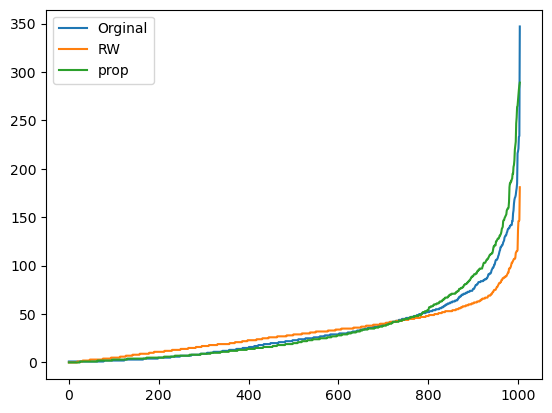

In [118]:
%matplotlib inline
deg_frame.plot()
plt.show()

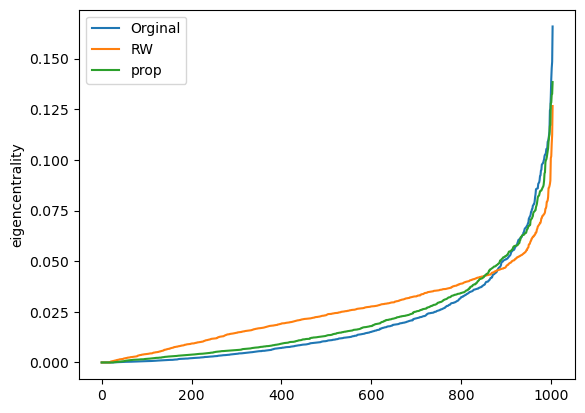

In [119]:
eig_frame.plot(ylabel="eigencentrality")
plt.show()

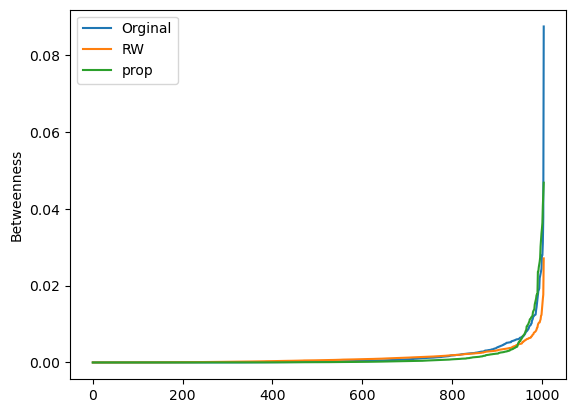

In [120]:
bet_frame.plot(ylabel="Betweenness")
plt.show()

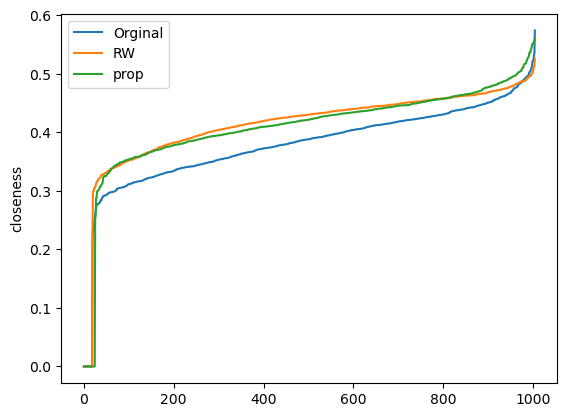

In [121]:
closenss_frame.plot(ylabel="closeness")
plt.show()

## Notes 
1. Larger ranks? Up 10 perhaps
2. Perhaps consider average over runs 
3. Remove loners and do analysis on largest cc component 
4. All methods 

In [122]:
A = nx.adjacency_matrix( G_original).todense()
np.linalg.matrix_rank(A)

986

In [129]:
mx = 0
idx = 0
i = 0
for S in nx.connected_components(G_original):
    B = nx.subgraph(G, S)
    A = nx.adjacency_matrix(B).todense() 
    print( (np.linalg.norm(A, ord="fro") / np.linalg.norm(A, ord=2) )**2  ) ## stable rank 
    if(len(S) > mx ):
        mx = len(S)
        idx = i
    i += 1

5.245903891456791
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/var/folders/dg/qkdn3m7j5nb83sd6976cxrkr0000gn/T/ipykernel_93686/1162040598.py:7: RuntimeWarning: invalid value encountered in scalar divide
  print( (np.linalg.norm(A, ord="fro") / np.linalg.norm(A, ord=2) )**2  )
